In [19]:
from google.colab import files

In [20]:
uploaded = files.upload()

Saving FAM.ped to FAM (1).ped


In [21]:
FAM_path = '/content/FAM.ped'
files={
    'file': ('FAM.ped', open(FAM_path, 'rb'), 'text/plain')
}

In [22]:
!apt-get update -qq && apt-get install -qq -y graphviz libgraphviz-dev
!pip install graphviz networkx pandas pygraphviz

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [23]:
import io
from graphviz import Digraph
import networkx as nx
import pandas as pd
import os # Import os for path checking

def get_shape_from_sex(sex):
    if sex == 1:
        return 'square'
    elif sex == 2:
        return 'circle'
    else:
        return 'diamond'

def make_pedigree_graph(df):
  G = nx.DiGraph()
  g = Digraph(format='svg') # Initialize the Graphviz object here
  g.attr('graph', rankdir='TB') # Set graph attributes

  for _, row in df.iterrows():
    node_id = str(row['iid']) # Corrected from 'id' to 'iid'
    sex = row['sex']
    pheno = row['pheno']
    shape = get_shape_from_sex(sex)
    label = f"{row['iid']}"

    G.add_node(node_id, sex=sex, pheno=pheno) # Add node to networkx graph

    if pheno == 2:
      g.node(node_id, label=label, shape=shape, style='filled')
    else:
      g.node(node_id, label=label, shape=shape)

  return G, g

# Dynamically get the filename from the 'uploaded' dictionary or read directly
ped_filename = 'FAM.ped' # Assuming this is the name of the uploaded file

# Check if 'uploaded' is defined and not empty, otherwise try to read from disk
if 'uploaded' in locals() and uploaded:
    uploaded_filename = list(uploaded.keys())[0]
    # Read the PED file directly from the byte stream in the 'uploaded' dictionary
    df = pd.read_csv(io.BytesIO(uploaded[uploaded_filename]), sep='\t', header=None, names=['fid', 'iid', 'pid', 'mid', 'sex', 'pheno'])
elif os.path.exists(ped_filename):
    # Fallback to reading from disk if file exists (e.g., after a Colab runtime restart)
    df = pd.read_csv(ped_filename, sep='\t', header=None, names=['fid', 'iid', 'pid', 'mid', 'sex', 'pheno'])
else:
    raise FileNotFoundError("No PED file found. Please upload a file named 'FAM.ped' or ensure 'files.upload()' was executed.")

# First, get the initialized Graphviz object 'g' with individual nodes
G_nx, g = make_pedigree_graph(df)

# Define the output filename for the SVG
outname = "pedigree_chart"

# Re-initialize unique_marriage_nodes and couples for this consolidated logic
unique_marriage_nodes = {}
couples = {}

# Iterate through the DataFrame to add all parent-child and marriage edges
for _, child in df.iterrows():
    child_id = str(child['iid'])
    pid = None
    if child['pid'] != 0:
        pid = str(child['pid'])
    mid = None
    if child['mid'] != 0:
        mid = str(child['mid'])

    if pid and mid:
        # Both parents are known, create/use a marriage node
        parent_pair_key = tuple(sorted((pid, mid)))
        mnode_id = None
        if parent_pair_key not in unique_marriage_nodes:
            mnode_id = f"mnode_{pid}_{mid}"
            g.node(mnode_id, label='', shape='point', width='0.01') # Phantom node for marriage
            g.edge(pid, mnode_id, arrowhead='none')
            g.edge(mid, mnode_id, arrowhead='none')
            unique_marriage_nodes[parent_pair_key] = mnode_id
        else:
            mnode_id = unique_marriage_nodes[parent_pair_key]
        g.edge(mnode_id, child_id) # Connect marriage node to child
    elif pid or mid:
        # Only one parent is known, connect directly to child
        parent = pid if pid else mid
        g.edge(parent, child_id)

# Render the final pedigree graph
g.render(filename=outname, cleanup=True)
print(f"Wrote {outname}.svg")

Wrote pedigree_chart.svg


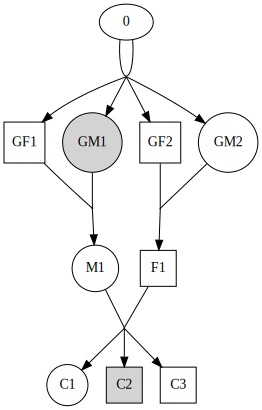

In [24]:
from IPython.display import SVG

# Display the generated SVG file
SVG(filename='pedigree_chart.svg')

In [25]:
def pedigree_statistics(df):
    stats = {
        "Total individuals": len(df),
        "Males": (df['sex'] == 1).sum(),
        "Females": (df['sex'] == 2).sum(),
        "Affected": (df['pheno'] == 2).sum(),
        "Unaffected": (df['pheno'] == 1).sum()
    }

    stats["Affected percentage"] = round(
        100 * stats["Affected"] / stats["Total individuals"], 2
    )

    return stats

In [26]:
def infer_inheritance(df):
    affected = df[df['pheno'] == 2]

    males = affected[affected['sex'] == 1]
    females = affected[affected['sex'] == 2]

    recessive_evidence = 0
    for _, row in affected.iterrows():
        pid, mid = str(row['pid']), str(row['mid']) # Ensure pid and mid are strings for consistent comparison
        if pid != '0' and mid != '0': # Corrected: compare to string '0'
            father_pheno_series = df[df['iid'] == pid]['pheno']
            mother_pheno_series = df[df['iid'] == mid]['pheno']

            if not father_pheno_series.empty and not mother_pheno_series.empty:
                father = father_pheno_series.values[0]
                mother = mother_pheno_series.values[0]
                if father == 1 and mother == 1:
                    recessive_evidence += 1

    if len(males) > 2 * len(females):
        return "Likely X-linked recessive"

    if recessive_evidence > 0:
        return "Likely autosomal recessive"

    return "Likely autosomal dominant"

pattern = infer_inheritance(df)
print("Inferred inheritance pattern:", pattern)

Inferred inheritance pattern: Likely autosomal recessive


In [27]:
stats = pedigree_statistics(df)
pattern = infer_inheritance(df)

print("Pedigree Report")
for k, v in stats.items():
    print(f"{k}: {v}")

print("Inheritance pattern:", pattern)

Pedigree Report
Total individuals: 9
Males: 5
Females: 4
Affected: 2
Unaffected: 7
Affected percentage: 22.22
Inheritance pattern: Likely autosomal recessive
